In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q pytorch_lightning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from torchmetrics.functional import accuracy

In [ ]:
SUDDEN_DOWN=0
SUDDEN_DOWN_NONE = 1
SUDDEN_UPP=2
SUDDEN_UPP_NONE = 3
DOWN=4
UPP=5
NONE=6

In [ ]:
import shutil
shutil.copy('/content/drive/MyDrive/ＦX予測/Method.py', '/content')

'/content/Method.py'

In [ ]:
import Method

In [ ]:
a = nn.Conv1d(1, 500, 40, 4)
b = nn.MaxPool1d(40,4)
c = nn.Linear(500*13,10)
d = torch.rand([1,400])
h = a(d)
h = b(h)
h = h.view(-1,500*13)
h = c(h)
h.shape

torch.Size([1, 10])

In [ ]:
class Net(pl.LightningModule):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.BatchNorm1d(input),
        nn.Conv1d(1, 500, 40, 4),
        nn.MaxPool1d(40,4),
        nn.Linear(input,500*91),
        nn.ReLU(),
        nn.BatchNorm1d(500*91),
        nn.Linear(500*91,200),
        nn.ReLU(),
        nn.BatchNorm1d(200),
        nn.Linear(200,100),
        nn.ReLU(),
        nn.Linear(100,output)
        )
  def forward(self,x):
    return self.model(x)
  def up_down_step(self, y, t,category="train"):
    weight = torch.tensor([1,1,1,1,1, 1, up_down_weight*0.7]).cuda()
    loss = F.binary_cross_entropy(y.softmax(dim=-1),t,weight)
    self.log(f'{category}_up_down', accuracy(y.softmax(dim=-1),t.to(torch.int64)), on_step=(category=="train"), on_epoch=True, prog_bar=(category=="train"))
    return loss
  def sudden_down_step(self, y,t,category="train"):
    weight = torch.tensor([1,down_weight,1,1,1, 1, 1]).cuda()
    loss = F.binary_cross_entropy(torch.sigmoid(y), t,weight)
    self.log(f'{category}_sudden_down', accuracy(y.softmax(dim=-1),t.to(torch.int64)), on_step=(category=="train"), on_epoch=True, prog_bar=(category=="train"))
    return loss
  def sudden_upp_step(self, y,t,category="train"):
    weight = torch.tensor([1,1,1,upp_weight,1, 1, 1]).cuda()
    loss = F.binary_cross_entropy(torch.sigmoid(y), t,weight)
    self.log(f'{category}_sudden_upp', accuracy(y.softmax(dim=-1),t.to(torch.int64)), on_step=(category=="train"), on_epoch=True, prog_bar=(category=="train"))
    return loss
  def step(self, batch, batch_idx, category="train"):
    x, t = batch
    y = self(x)
    loss = self.sudden_down_step(y[:2],t[:2],category)
    loss += self.sudden_upp_step(y[2:4],t[2:4], category) 
    loss += self.up_down_step(y[4:],t[4:],category)
    return loss
  def training_step(self, batch, batch_idx):
    return self.step(batch, batch_idx)
  # 検証データに対する処理
  def validation_step(self, batch, batch_idx):
    return self.step(batch,batch_idx, "val")
  # テストデータに対する処理
  def test_step(self, batch, batch_idx):
    return self.step(batch,batch_idx,"test")
  def configure_optimizers(self):
   optimizer = torch.optim.Adam(self.parameters(), lr=0.00001)
   return optimizer

In [ ]:
df = pd.read_hdf("/content/drive/MyDrive/ＦX予測/data/EURUSD_M5_100length_B1_4.h5")

In [ ]:
ans = pd.read_hdf("/content/drive/MyDrive/ＦX予測/ans/EURUSD_M5_100length_ansA1_4.h5")

In [ ]:
df

,OPEN_99,HIGH_99,LOW_99,CLOSE_99,OPEN_98,HIGH_98,LOW_98,CLOSE_98,OPEN_97,HIGH_97,...,LOW_2,CLOSE_2,OPEN_1,HIGH_1,LOW_1,CLOSE_1,OPEN_0,HIGH_0,LOW_0,CLOSE_0
0,0.0,0.0,-8.0,-4.0,-7.0,1.0,-8.0,1.0,0.0,1.0,...,-48.0,-47.0,-17.0,-9.0,-48.0,-35.0,-23.0,-5.0,-23.0,-18.0
1,0.0,4.0,-5.0,2.0,3.0,3.0,-5.0,-1.0,-4.0,4.0,...,-52.0,-34.0,-41.0,-24.0,-45.0,-44.0,-14.0,-6.0,-45.0,-32.0
2,0.0,40.0,0.0,40.0,-1.0,3.0,-6.0,1.0,2.0,2.0,...,-36.0,-24.0,-33.0,-30.0,-53.0,-35.0,-42.0,-25.0,-46.0,-45.0
3,0.0,0.0,-16.0,-16.0,-16.0,24.0,-16.0,24.0,-17.0,-13.0,...,-50.0,-43.0,-50.0,-20.0,-52.0,-40.0,-49.0,-46.0,-69.0,-51.0
4,0.0,2.0,-3.0,0.0,15.0,15.0,-1.0,-1.0,-1.0,39.0,...,-35.0,-29.0,-28.0,-22.0,-35.0,-28.0,-35.0,-5.0,-37.0,-25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429498,0.0,3.0,-2.0,-1.0,2.0,3.0,-1.0,-1.0,3.0,5.0,...,-8.0,-3.0,-10.0,-3.0,-11.0,-6.0,-10.0,-5.0,-11.0,-11.0
429499,0.0,3.0,-2.0,-1.0,2.0,5.0,0.0,1.0,4.0,5.0,...,-5.0,-3.0,-3.0,-1.0,-6.0,-1.0,-8.0,-1.0,-9.0,-4.0
429500,0.0,5.0,0.0,3.0,2.0,5.0,0.0,1.0,4.0,7.0,...,-2.0,4.0,-1.0,4.0,-3.0,-1.0,-1.0,1.0,-4.0,1.0
429501,0.0,2.0,-2.0,0.0,-4.0,1.0,-4.0,-1.0,-2.0,1.0,...,-4.0,-2.0,-5.0,1.0,-6.0,0.0,-5.0,0.0,-7.0,-5.0


In [ ]:
ans

,SUDDEN_DOWN,SUDDEN_DOWN_NONE,SUDDEN_UPP,SUDDEN_UPP_NONE,DOWN,UPP,NONE
0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
1,0.0,1.0,1.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.0,1.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...
429497,0.0,1.0,0.0,1.0,0.0,0.0,1.0
429498,0.0,1.0,0.0,1.0,0.0,0.0,1.0
429499,0.0,1.0,0.0,1.0,0.0,0.0,1.0
429500,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [ ]:
input = df.shape[1]
output = ans.shape[1]
input,output

(400, 7)

In [ ]:
down_weight = len(ans[ans.SUDDEN_DOWN==1])/len(ans[ans.SUDDEN_DOWN_NONE==1]) 
len(ans[ans.SUDDEN_DOWN==1]),len(ans[ans.SUDDEN_DOWN_NONE==1]) ,down_weight

(669, 428833, 0.0015600478507950648)

In [ ]:
upp_weight = len(ans[ans.SUDDEN_UPP==1])/len(ans[ans.SUDDEN_UPP_NONE==1])
len(ans[ans.SUDDEN_UPP==1]),len(ans[ans.SUDDEN_UPP_NONE==1]),upp_weight

(712, 428790, 0.0016604864852258682)

In [ ]:
up_down_weight = (len(ans[ans.UPP==1])+len(ans[ans.DOWN == 1]))/len(ans[ans.NONE == 1])
len(ans[ans.UPP==1]),len(ans[ans.DOWN == 1]),len(ans[ans.NONE == 1]),up_down_weight

(37704, 37551, 354247, 0.21243652028104684)

In [ ]:
(len(ans[ans.UPP==1])+len(ans[ans.DOWN == 1]))/len(ans[ans.NONE == 1])

0.21243652028104684

In [ ]:
train,val,test = Method.make_tensor_dataset(df,ans,dtype=[torch.float32,torch.float32], ratio=[0.6,0.2])
train_loader,val_loader,test_loader = Method.make_loader(train,val,test, batch_size=50)

AssertionError: ignored

In [ ]:
#メモリ節約
del(df)
del(ans)

In [ ]:
shutil.copy('/content/drive/MyDrive/ＦX予測/Model1.py', '/content')
import Model1

In [ ]:
#net = Model1.Net()
net = Net()

In [ ]:
log=0

In [ ]:
log

0

In [ ]:
net.load_state_dict(torch.load('/content/drive/MyDrive/ＦX予測/model/LinearModel_ansAver1.pth'))

<All keys matched successfully>

In [ ]:
pl.seed_everything(0)
trainer = Method.use_model(net,train_loader,val_loader, 20)

Global seed set to 0
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 27.4 M
-------------------------------------
27.4 M    Trainable params
0         Non-trainable params
27.4 M    Total params
109.557   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

RuntimeError: ignored

In [ ]:
log+=1

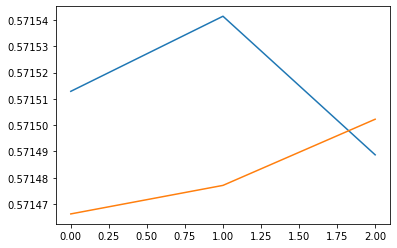

In [ ]:
Method.draw_graph("up_down",log)

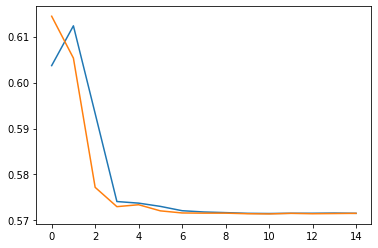

In [ ]:
Method.draw_graph("sudden_down",log)

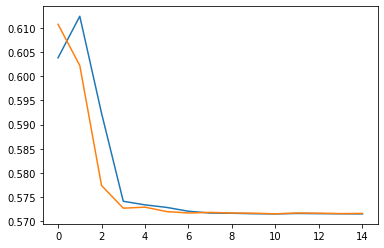

In [ ]:
Method.draw_graph("sudden_upp",log)

In [ ]:
results = trainer.test(net, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    test_sudden_down        0.5714678168296814
     test_sudden_upp        0.5715376138687134
      test_up_down           0.571539580821991
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [ ]:
Method.score_test(test,net)

score -632
active_acc 36
active_loss 128
passive_acc 77541
passive_loss 8197


In [ ]:
torch.save(net.state_dict(), "/content/drive/MyDrive/ＦX予測/model/LinearModel_ansAver1.pth")

In [ ]:
device = torch.device("cpu")
net.eval()
traced_net = torch.jit.trace(net, torch.rand(1,input).to(device))
traced_net.save("SampleNet2.pt")

# 入力するtensorの次元は本家から調べて合わせる
# 次元さえ合っていれば何でも良い．
traced_net = torch.jit.trace(net, torch.rand(1,input).to(device))
traced_net.save("SampleNet2.pt")

/usr/local/lib/python3.7/dist-packages/torch/_jit_internal.py:668: LightningDeprecationWarning: The `LightningModule.model_size` property was deprecated in v1.5 and will be removed in v1.7. Please use the `pytorch_lightning.utilities.memory.get_model_size_mb`.
  if hasattr(mod, name):
/usr/local/lib/python3.7/dist-packages/torch/_jit_internal.py:669: LightningDeprecationWarning: The `LightningModule.model_size` property was deprecated in v1.5 and will be removed in v1.7. Please use the `pytorch_lightning.utilities.memory.get_model_size_mb`.
  item = getattr(mod, name)
/usr/local/lib/python3.7/dist-packages/torch/_jit_internal.py:668: LightningDeprecationWarning: `LightningModule.use_amp` was deprecated in v1.6 and will be removed in v1.8. Please use `Trainer.amp_backend`.
  if hasattr(mod, name):
/usr/local/lib/python3.7/dist-packages/torch/_jit_internal.py:669: LightningDeprecationWarning: `LightningModule.use_amp` was deprecated in v1.6 and will be removed in v1.8. Please use `Traine